# Extracting the simulations at same noise level.

What is the distribution of returned parameters when repeating the same simulation (fixed snr also) so only the random noise changes.

This is not very interesting atm as I need more samples which are running on exo currently.
Some have a distribution while others are at either ends of the parameter grid limits I set.


In [4]:
import re
import os
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import glob
import sqlalchemy as sa
from bin.coadd_analysis_script import load_sql_table
%matplotlib inline


In [5]:
import yaml
# Get the range of parameters used in simulation from config file.
def get_sim_grid(path="/home/jneal/Phd/Analysis/sims_variable_params_same_snr/"):
    config_file = os.path.join(path, "config.yaml")
    with open(config_file) as f:
        config = yaml.load(f)
    return config["sim_grid"]

sim_grid = get_sim_grid()
print(sim_grid)

{'gammas': [-7, 3, 0.5], 'rvs': [6, 14, 0.5], 'teff_1': [-600, 600, 100], 'teff_2': [-800, 801, 100], 'feh_1': [-0.0, 1.01, 5.5], 'feh_2': [-0.0, 1.01, 5.5], 'logg_1': [0, 1.5, 2.5], 'logg_2': [0, 1.5, 2.5], 'arb_norm': [0.95, 1.05, 0.01]}


In [6]:
import glob
class SnrDistribution(object):
    def __init__(self, df, snr, teff):
        #ddf.to_numeric(s, errors='coerce')
        self.df = df
        self.snr = snr
        self.teff = teff
        self.size = len(self.df)
        
    
    def mean(self, column, nan=True):
        try:
            if nan:
                return np.nanmean(self.df[column])
            else: 
                return np.mean(self.df[column])
        except KeyError:
            return np.nan
        
    def std(self, column, nan=True):
        try:
            if nan:
                return np.nanstd(self.df[column])
            else: 
                return np.std(self.df[column])
        except KeyError:
            return np.nan
        
    def values(self, column, nan=True):
        try:
            return self.df[column].values
        except KeyError:
            return np.nan

In [7]:
class SimReader(object):
    def __init__(self, base="/home/jneal/Desktop/Inbox/a/bhm_noise_sim/analysis",
                 namebase="BSBHMNOISE",
                 prefix="", mode="bhm", chi2_val="coadd_chi2"):
        self.base = base
        self.namebase = namebase.upper()
        self.prefix = prefix.upper()
        if mode in ["iam", "tcm", "bhm"]:
            self.mode = mode
        else:
            raise ValueError("Invalid SimReader mode")
        if chi2_val in ["chi2_1", "chi2_2", "chi2_3", "chi2_4", "coadd_chi2"]:
            self.chi2_val = chi2_val
        else:
            raise ValueError("Invalid chi2_val.")
    
    def list_sims(self):
        return glob.glob(os.path.join(self.base, "*"))
    
    def load_results(self, teff, snr):
        starname = "{}{}{}N{}".format(self.prefix, self.namebase, teff, snr)
        directory = os.path.join(self.base, starname, self.mode)
        df_store = pd.DataFrame()
        # print(directory)
        dbs = glob.glob(os.path.join(directory, "*_coadd_{}_chisqr_results.db".format(self.mode)))
        for dbname in dbs:
            # print(dbname)
            match = re.search("N\d{1,4}-(\d{1,5})_coadd_"+"{}".format(self.mode), dbname, flags=0)
            obsnum = match.group(1)
            try:
                table = load_sql_table(dbname, verbose=False, echo=False)
                dbdf = pd.read_sql(sa.select(table.c).order_by(table.c[self.chi2_val].asc()).limit(1), table.metadata.bind)
                dbdf["snr"] = snr   # Add SNR column
                dbdf["obsnum"] = obsnum # Add Obsnum column
                df_store = dbdf.append(df_store)
            except Exception as e:
                print(e)
                print(f"Didn't get Database for teff={teff}-snr={snr}-obsnum={obsnum}")
        # Coerce to be numeric columns
        c = df_store.columns[df_store.dtypes.eq(object)]
        df_store[c] = df_store[c].apply(pd.to_numeric, errors='coerce', axis=0)
        return SnrDistribution(df_store, snr=snr, teff=teff)


In [8]:
import matplotlib.lines as lines
import matplotlib.colors as colors
lines_array = list(lines.lineStyles.keys())
colors_array = list(colors.cnames.keys())

def analysis_param(df_store, param, index, individual=False, values=False, reference=None):
    if individual:
        plt.figure()
    for i, t in enumerate(df_store):
        # print(i, t, len(t))
        means = [df.mean(param) for df in t]
        std = [df.std(param) for df in t]
        
        label = "{}".format(index[i])
        teff_comp = label
        if label == "":
            label = "None"
        plt.errorbar(noises, means, std, marker=".", label=label, ls=lines_array[i])
        
        if reference is not None:
            reference["teff_2"] = teff_comp
            this_value = reference[param]
            if isinstance(this_value, dict):
                this_value = this_value(teff_comp)
            print(this_value, type(this_value))
            plt.hlines(this_value, min(noises), max(noises), linestyle="--")
            
        if values:
            values = [df.values(param) for df in t]
            for n, noise in noises:
                plt.plot(noise*np.ones_like(values[nn]), values[nn], "o", ls=colors_array[i])
                
        if individual:
            plt.xlabel("SNR")
            plt.ylabel(param)
            plt.legend()
            plt.title("Distribution of individual IAM simulated results. {}". format(param))
            plt.show()
    plt.xlabel("SNR")
    plt.ylabel(param)
    plt.legend()
    plt.title("Distribution of IAM simulated results.")
    plt.show()
    

In [10]:
IAMSimReader = SimReader(base="/home/jneal/Desktop/Inbox/a/sims_var_params_same_snr/analysis",
                         namebase="NEWNOISESCRIPT",
                         prefix="",
                         mode="iam")

sim_grid = get_sim_grid(IAMSimReader.base+"/..")
IAMSimReader.list_sims()

LINIAMSimReader = SimReader(base="/home/jneal/Desktop/Inbox/a/sims_var_params_same_snr/analysis",
                         namebase="LINNEWNOISESCRIPT",
                         prefix="",
                         mode="iam")

In [11]:
noises = [0, 20, 100, 500]
teffs = [2300, 3400, 40000]  #, 3400]

IAMSimReader = SimReader(base="/home/jneal/Desktop/Inbox/a/sims_var_params_same_snr/analysis",
                         namebase="NEWNOISESCRIPT",
                         prefix="",
                         mode="iam")
sim_grid = get_sim_grid(IAMSimReader.base+"/..")
print(sim_grid)
df_store = [[0]*len(noises) for n in range(len(teffs))]
print(df_store)

for i, teff in enumerate(teffs):
    print("teff = {}".format(teff))
    for j, noise in enumerate(noises):
        df = IAMSimReader.load_results(teff, noise)   
        df_store[i][j] = df

print("Done")

{'gammas': [-7, 3, 0.5], 'rvs': [6, 14, 0.5], 'teff_1': [-600, 601, 100], 'teff_2': [-800, 801, 100], 'feh_1': [0, 1.01, 1.5], 'feh_2': [0, 1.01, 1.5], 'logg_1': [-0.5, 0.51, 0.5], 'logg_2': [-0.5, 0.51, 0.5], 'arb_norm': [0.95, 1.05, 0.01]}
[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
teff = 2300
teff = 3400
teff = 40000
Done


In [8]:
"/home/jneal/Desktop/Inbox/a/sims_var_params_same_snr/fixed_noise_runs.sh"

'/home/jneal/Desktop/Inbox/a/sims_var_params_same_snr/fixed_noise_runs.sh'

In [12]:
df_store[0][0].values("teff_1")

# Parameters used
with open(os.path.join(IAMSimReader.base, "../fixed_noise_runs.sh")) as f:
     for line in f:
            print(line)


#!\usr\bin bash



# Same noise level, redue parameter range for checking distributions of parameters.

noises=( 20 50 100 0 500)

for ITER in {1..5};

	do

        for NOISE in ${noises[@]};

		do

		iam_fake_full_stack.py newnoisescript2300n$NOISE $ITER 5200 4.5 0.0 2300 3.5 0.0 -2 10 -n $NOISE --no-plots

		iam_fake_full_stack.py newnoisescript3400n$NOISE $ITER 5200 4.5 0.0 3400 4.5 0.0 -2 10 -n $NOISE --no-plots

		iam_fake_full_stack.py newnoisescript4000n$NOISE $ITER 5200 5 -0.5 4000 4.5 0.5 -2 10 -n $NOISE --no-plots

		done

	done	

 



In [13]:
correct_values = {"gamma":-2, "rv": 10, "teff_1": 5200, 
          "logg_1": {"2300": 4.5, "3400": 4.5, "4000": 5, "40000": 5}, 
          "logg_2": {"2300": 3.5, "3400": 4.5, "4000": 4.5, "40000": 4.5}, 
          "feh_1": {"2300": 0, "3400": 0, "4000": -0.5, "40000": -0.5},
          "feh_2": {"2300": 0, "3400": 0, "4000": 0.5, "40000": 0.5}, }

5200 <class 'int'>
5200 <class 'int'>
5200 <class 'int'>


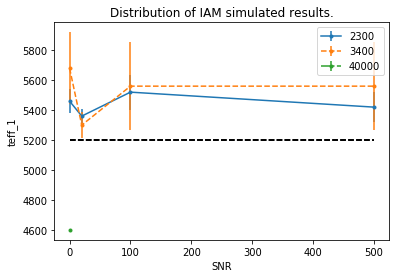

TypeError: 'dict' object is not callable

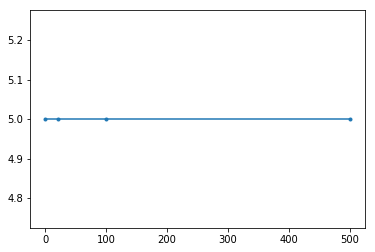

In [14]:
analysis_param(df_store, "teff_1", teffs, individual=False, reference=correct_values)
analysis_param(df_store, "logg_1", teffs, individual=False, reference=correct_values)
analysis_param(df_store, "feh_1", teffs, individual=False, reference=correct_values)
analysis_param(df_store, "gamma", teffs, individual=False, reference=correct_values)

analysis_param(df_store, "teff_2", teffs, individual=False, reference=correct_values)
analysis_param(df_store, "logg_2", teffs, individual=False, reference=correct_values)
analysis_param(df_store, "feh_2", teffs, individual=True, reference=correct_values)
analysis_param(df_store, "rv", teffs, individual=False, reference=correct_values)


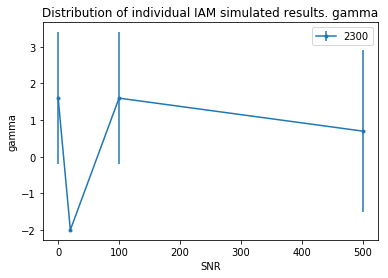

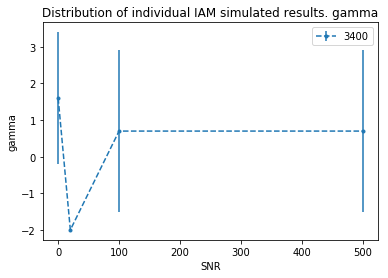

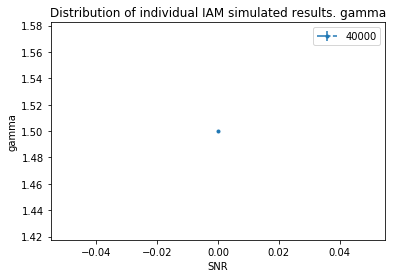

No handles with labels found to put in legend.


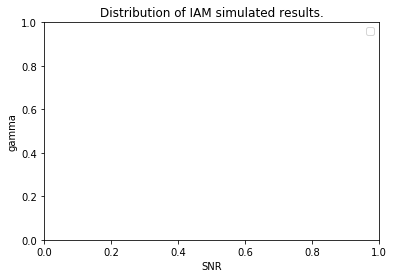

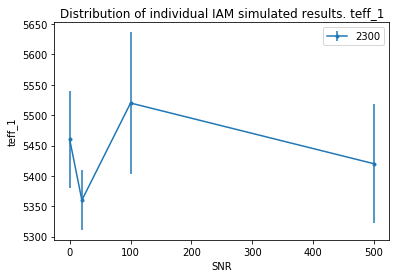

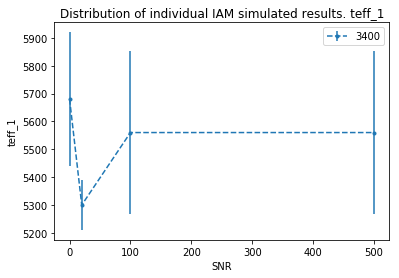

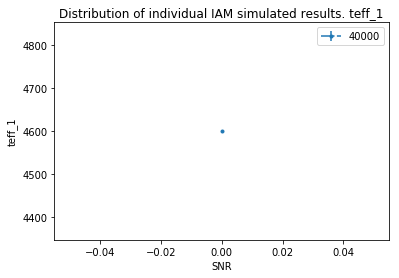

No handles with labels found to put in legend.


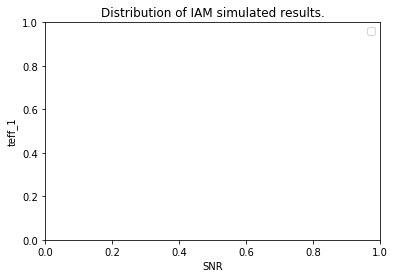

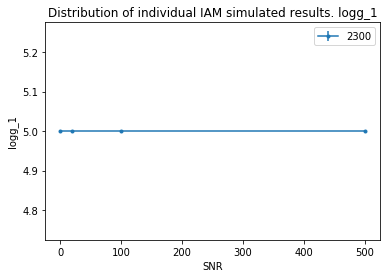

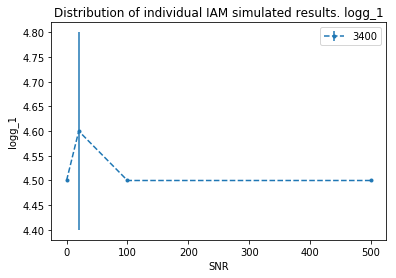

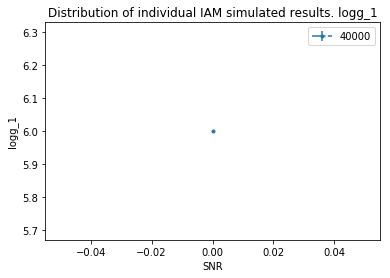

No handles with labels found to put in legend.


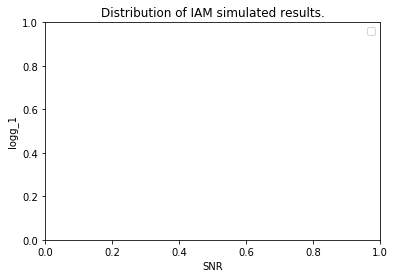

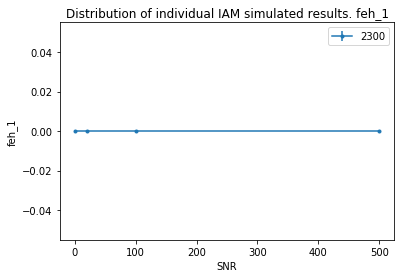

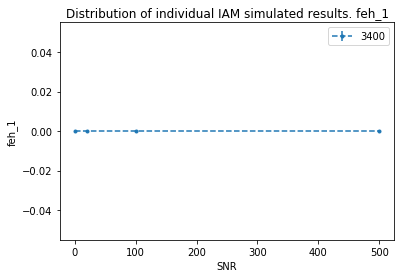

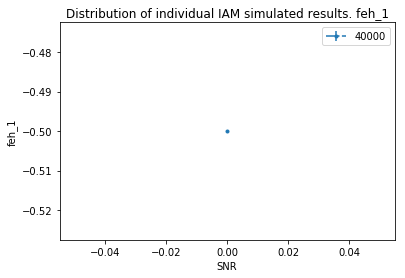

No handles with labels found to put in legend.


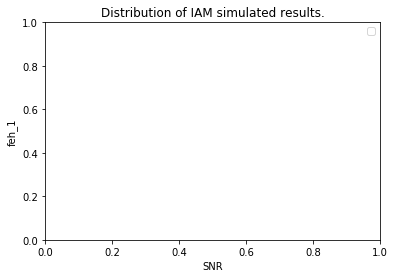

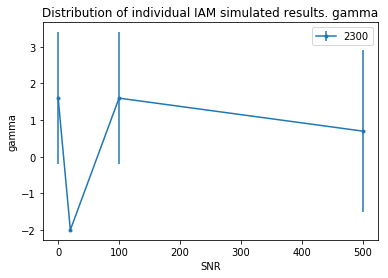

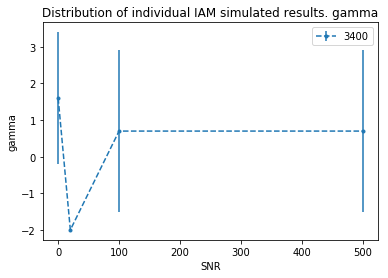

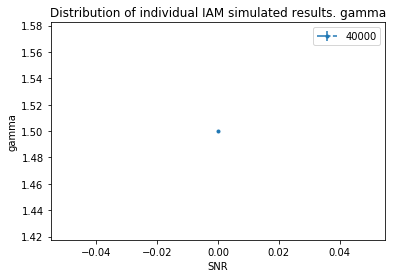

No handles with labels found to put in legend.


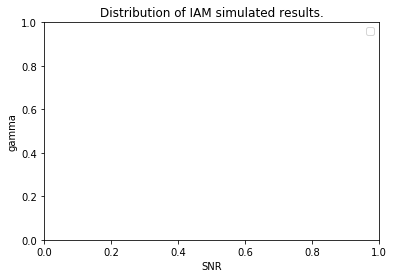

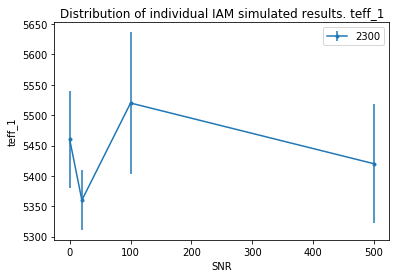

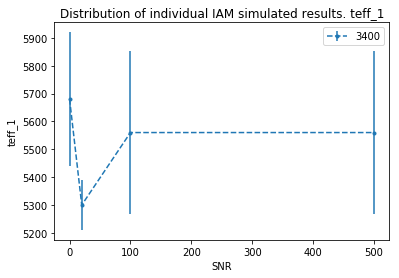

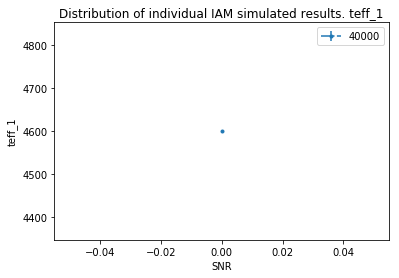

No handles with labels found to put in legend.


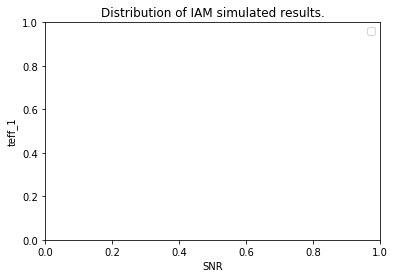

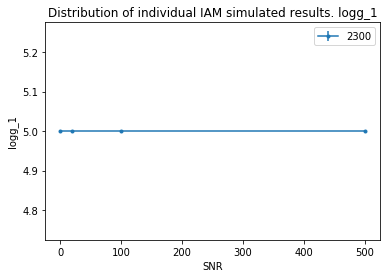

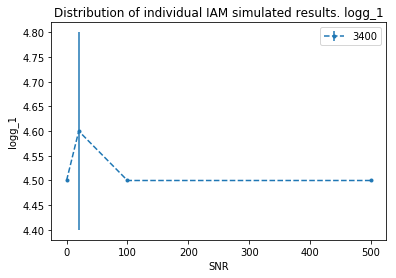

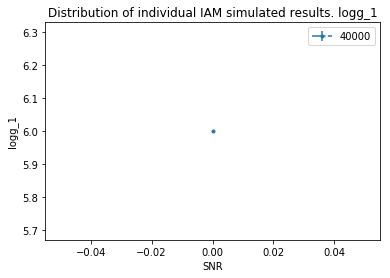

No handles with labels found to put in legend.


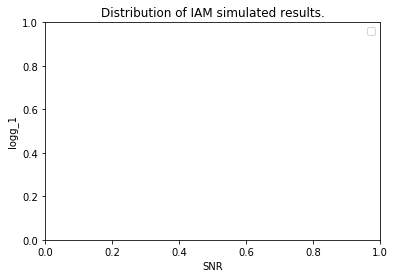

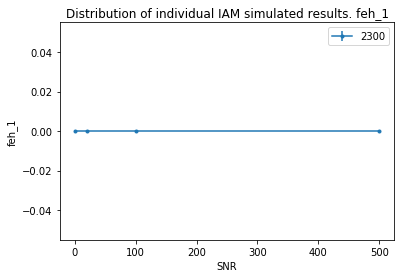

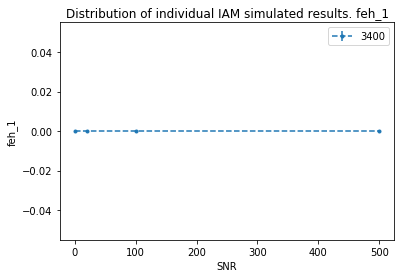

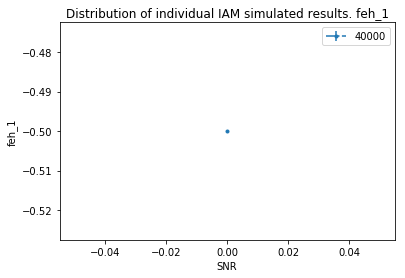

No handles with labels found to put in legend.


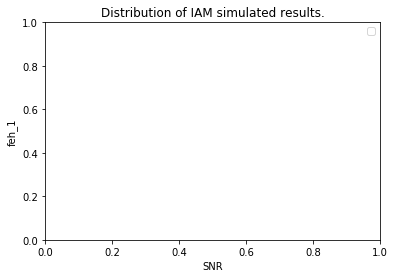

In [15]:

analysis_param(df_store, "gamma", teffs, individual=True)
analysis_param(df_store, "teff_1", teffs, individual=True)
analysis_param(df_store, "logg_1", teffs, individual=True)
analysis_param(df_store, "feh_1", teffs, individual=True)
analysis_param(df_store, "gamma", teffs, individual=True)
analysis_param(df_store, "teff_1", teffs, individual=True)
analysis_param(df_store, "logg_1", teffs, individual=True)
analysis_param(df_store, "feh_1", teffs, individual=True)


In [ ]:
# Older code

In [ ]:
chi2_val = "coadd_chi2"
import re

def load_fixed_snr(teff, snr):
    base = "/home/jneal/Phd/Analysis/sims_variable_params_same_snr/analysis/"
    starname = "NOISESCRIPT{}N{}".format(teff, snr)
    directory = os.path.join(base, starname, "iam")
    df_store = pd.DataFrame()
    
    dbs = glob.glob(os.path.join(directory, "*_coadd_iam_chisqr_results.db"))
    print(len(dbs))
    
    for dbname in dbs:
        match = re.search("N\d{1,4}-(\d{1,5})_coadd_iam", dbname, flags=0)
        obsnum = match.group(1)
        try:
            table = load_sql_table(dbname, verbose=False, echo=False)
            dbdf = pd.read_sql(sa.select(table.c).order_by(table.c[chi2_val].asc()).limit(1), table.metadata.bind)
            dbdf["snr"] = snr   # Add SNR column
            dbdf["obsnum"] = obsnum # Add Obsnum column
            df_store = dbdf.append(df_store)
        except Exception as e:
            print(e)
            print(f"Didn't get Database for teff={teff}-snr={snr}-obsnum={obsnum}")
    
    # print("Results")
    # print("Host Temperature = 5200 K, Companion Temperature = {}".format(teff))
    # df_store["median_alpha"] = df_store.apply(lambda row: np.median([row.alpha_1, row.alpha_2, row.alpha_3, row.alpha_4]), axis=1)
    # print(df_store[["snr", "obsnum", "coadd_chi2", "teff_1", "teff_2", "median_alpha"]])
    return df_store




In [ ]:
noises = [0, 20, 50, 100, 1000]
teffs = [2500]  #, 3400]


#df_store = [[0]* len(teffs) for n in range(len(noises))]
#print(df_store)

#for i, noise in enumerate(noises):
#    print("NOISE = {}".format(noise))
#    for j, teff in enumerate(teffs):
#        df = load_fixed_snr(teff, noise)   
#        df_store[i][j] = df
        


In [ ]:

def analyse_fixed_snr(df, teff, snr):
    
    sim_grid = get_sim_grid()
    teff_1_limits = [t + 5200 for t in sim_grid["teff_1"][0:2]]
    teff_2_limits = [t + teff for t in sim_grid["teff_2"][0:2]]
    
    df.plot(x="obsnum", y="teff_1", kind="hist", style="*")
    starname = "NOISESCRIPT{}N{}".format(teff, snr)
    plt.title(starname)

    df.plot(x="obsnum", y="teff_2", kind="hist")
    starname = "NOISESCRIPT{}N{}".format(teff, snr)
    plt.title(starname)
    
    df.plot(x="obsnum", y="coadd_chi2", kind="hist")
    starname = "$\chi^2$ NOISESCRIPT{}N{}".format(teff, snr)
    plt.title(starname)
    
    df.plot( y="gamma", kind="hist")
    df.plot(x="teff_1", y="gamma", kind="scatter", xlim=teff_1_limits, ylim=sim_grid["gammas"][0:2])
    df.plot(x="teff_2", y="gamma", kind="scatter", xlim=teff_2_limits, ylim=sim_grid["gammas"][0:2])
    df.plot(x="teff_1", y="rv", kind="scatter", xlim=teff_1_limits, ylim=sim_grid["rvs"][0:2])
    df.plot(x="teff_2", y="rv", kind="scatter", xlim=teff_2_limits, ylim=sim_grid["rvs"][0:2])
    df.plot(x="teff_1", y="teff_2", kind="scatter", xlim=teff_1_limits, ylim=teff_2_limits)
    
    plt.show()
    
    print("Standard deviations of values\n", df.std(axis=0)[["teff_1", "teff_2", "coadd_chi2", "gamma", "rv"]])
    

In [ ]:
for i, noise in enumerate(noises):
    print("NOISE = {}".format(noise))
    for j, teff in enumerate(teffs): 
        analyse_fixed_snr(df_store[i][j], teff, noise)      
        
        